In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras 

%matplotlib inline

In [523]:
from importlib import reload
import dense_variational_v2 as dvar
reload(dvar)

<module 'dense_variational_v2' from '/home/rlx/Dropbox/teaching/ppdl.dev/content/04.02 - Variational Inference/dense_variational_v2.py'>

https://rpubs.com/bacti/tensorflow-probabilistic

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype, trainable=False),
        tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
    ])


In [443]:
# kernel_size: the number of parameters in the dense weight matrix
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tdf.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype),
                                                scale=1),
                                     reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfp.layers.VariableLayer(tfp.layers.IndependentNormal.params_size(n), dtype=dtype),
        tfp.layers.IndependentNormal(n)
    ])

In [630]:
def make_prior(kernel_size, bias_size, dtype=tf.float32):
    n = kernel_size + bias_size
    print ("make prior", kernel_size, bias_size)
    m = Sequential([
            tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=-10*tf.ones(n, dtype=dtype), scale=1))
        ])
    return m

def make_posterior(kernel_size, bias_size, dtype=tf.float32):
    n = kernel_size + bias_size
    print ("make posterior", kernel_size, bias_size)
    m = Sequential([
            tfp.layers.VariableLayer(n),
            tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1), 
                                          convert_to_tensor_fn=tfp.distributions.Distribution.sample)
        ])
    return m


In [657]:
reload(dvar)
model = Sequential([
    dvar.XDenseVariational(input_shape=(1, ), units=1, 
                          make_prior_fn=make_prior, make_posterior_fn=make_posterior, 
                          kl_weight=1, kl_use_exact=False),
])

model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()

make posterior 1 1
make prior 1 1
-- CALLED with inputs Tensor("Placeholder:0", shape=(None, 1), dtype=float32)
-- POSTERIOR params Tensor("x_dense_variational_11/sequential/variable_layer/ReadVariableOp:0", shape=(2,), dtype=float32) 1
-- PRIOR     params Tensor("x_dense_variational_11/sequential_1/distribution_lambda_1/mul:0", shape=(2,), dtype=float32) 1
-- KERNEL Tensor("x_dense_variational_11/Reshape:0", shape=(1, 1), dtype=float32)
Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_dense_variational_11 (XDe  (None, 1)                2         
 nseVariational)                                                 
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [658]:
posterior = make_posterior(1,1)
prior = make_prior(1,1)

make posterior 1 1
make prior 1 1


In [659]:
model.layers[0].set_weights(np.r_[[[1.,0.]]])

In [660]:
x = np.r_[0.,0.,1.,2.,2.]

In [661]:
p = posterior(x)
p.parameters['loc'].numpy()

array([0., 0.], dtype=float32)

In [662]:
tf.convert_to_tensor(posterior(x))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.703736, -2.000312], dtype=float32)>

In [663]:
x = np.r_[0.,0.,1.,2.,2.].reshape(-1,1)
model(x)

-- CALLED with inputs tf.Tensor(
[[0.]
 [0.]
 [1.]
 [2.]
 [2.]], shape=(5, 1), dtype=float32)
-- POSTERIOR params tf.Tensor([1. 0.], shape=(2,), dtype=float32) 1
-- PRIOR     params tf.Tensor([-10. -10.], shape=(2,), dtype=float32) 1
-- KERNEL tf.Tensor([[1.4715037]], shape=(1, 1), dtype=float32)


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.34474808],
       [-0.34474808],
       [ 1.1267557 ],
       [ 2.5982594 ],
       [ 2.5982594 ]], dtype=float32)>

In [664]:
model.predict(x)

-- CALLED with inputs Tensor("IteratorGetNext:0", shape=(None, 1), dtype=float32)
-- POSTERIOR params Tensor("sequential_112/x_dense_variational_11/sequential/variable_layer/ReadVariableOp:0", shape=(2,), dtype=float32) 1
-- PRIOR     params Tensor("sequential_112/x_dense_variational_11/sequential_1/distribution_lambda_1/mul:0", shape=(2,), dtype=float32) 1
-- KERNEL Tensor("sequential_112/x_dense_variational_11/Reshape:0", shape=(1, 1), dtype=float32)


array([[-0.05460121],
       [-0.05460121],
       [ 0.51036006],
       [ 1.0753213 ],
       [ 1.0753213 ]], dtype=float32)

In [665]:
prior(1,1)(x)

TypeError: '_TensorCoercible' object is not callable

In [666]:
n = 90000
x = 5*np.ones(n)
x[:n//3] = 0
x[-n//3:] = 10
s = model.predict(x)
ss = model(x).numpy()[:,0]

-- CALLED with inputs Tensor("sequential_112/ExpandDims:0", shape=(None, 1), dtype=float32)
-- POSTERIOR params Tensor("sequential_112/x_dense_variational_11/sequential/variable_layer/ReadVariableOp:0", shape=(2,), dtype=float32) 1
-- PRIOR     params Tensor("sequential_112/x_dense_variational_11/sequential_1/distribution_lambda_1/mul:0", shape=(2,), dtype=float32) 1
-- KERNEL Tensor("sequential_112/x_dense_variational_11/Reshape:0", shape=(1, 1), dtype=float32)
-- CALLED with inputs tf.Tensor(
[[ 0.]
 [ 0.]
 [ 0.]
 ...
 [10.]
 [10.]
 [10.]], shape=(90000, 1), dtype=float32)
-- POSTERIOR params tf.Tensor([1. 0.], shape=(2,), dtype=float32) 1
-- PRIOR     params tf.Tensor([-10. -10.], shape=(2,), dtype=float32) 1
-- KERNEL tf.Tensor([[1.078308]], shape=(1, 1), dtype=float32)


In [641]:
np.unique(ss)

array([ 1.1411604,  8.561324 , 15.981488 ], dtype=float32)

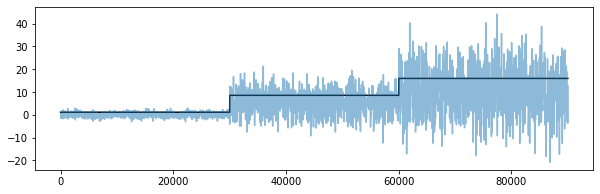

In [642]:
plt.figure(figsize=(10,3))
plt.plot(ss, color="black")
plt.plot(s, alpha=.5)


In [643]:
ss

array([ 1.1411604,  1.1411604,  1.1411604, ..., 15.981488 , 15.981488 ,
       15.981488 ], dtype=float32)

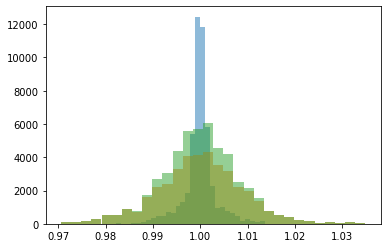

In [598]:
plt.hist(s[:50000], bins=30, alpha=.5);
plt.hist(s[50000:100000], bins=30, alpha=.5);
plt.hist(s[-50000:], bins=30, alpha=.5);

In [461]:
for ss in (s[:50000], s[50000:100000], s[-50000:]):
    print (ss.mean(), ss.std())

4.8716063 5.783361
18.094084 9.791212
16.557356 9.563629


In [462]:
for ss in (s[:50000], s[50000:100000], s[-50000:]):
    print (ss.mean(), ss.std())

4.8716063 5.783361
18.094084 9.791212
16.557356 9.563629


In [296]:
model.layers[0].weights

[<tf.Variable 'dense_variational_24/constant:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [298]:
x

array([ 0.,  0.,  0., ..., 10., 10., 10.])

In [ ]:
x = 5*np.ones(150000)
x[:50000] = 0
x[-50000:] = 10
s = model.predict(x)